In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from imblearn.over_sampling import SMOTE



In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Alex/EV_Car_reviews.xlsx')

print(df.head())
print(df.shape)
print(df.isnull().sum())



       Car  Rating                                             Review
0  Kia EV6     5.0  Very good performance car; haven't seen an ele...
1  Kia EV6     4.5  The KIA EV6 is a cool and eco-friendly electri...
2  Kia EV6     5.0  I don't personally own this car, but a relativ...
3  Kia EV6     4.0  KIA EV6 is sporty handling. The Seats are very...
4  Kia EV6     5.0  After using this car for more than 6 months, I...
(1099, 3)
Car       0
Rating    0
Review    0
dtype: int64


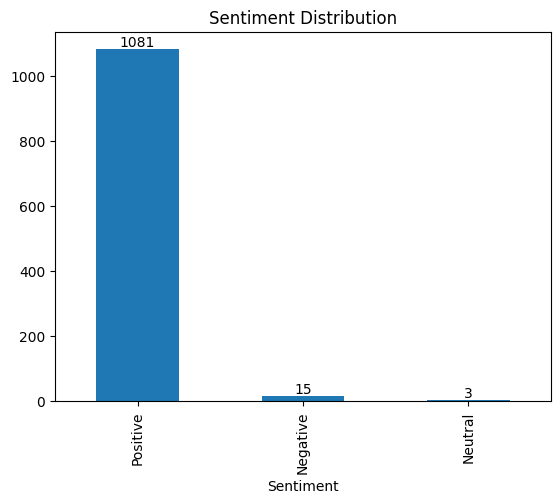

In [ ]:
def scoringPattern(rating):
    if rating > 3:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'


df['Sentiment'] = df['Rating'].map(scoringPattern)


ax = df['Sentiment'].value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.title("Sentiment Distribution")
plt.show()



In [ ]:
def removeHTMLTags(review):
    soup = BeautifulSoup(review, 'lxml')
    return soup.get_text()

def remove_apostrophes(review):
    review = re.sub(r"won't", "will not", review)
    review = re.sub(r"can't", "cannot", review)
    review = re.sub(r"n't", " not", review)
    review = re.sub(r"'re", " are", review)
    review = re.sub(r"'s", " is", review)
    review = re.sub(r"'d", " would", review)
    review = re.sub(r"'ll", " will", review)
    review = re.sub(r"'ve", " have", review)
    review = re.sub(r"'m", " am", review)
    return review

def removeAlphaNumeric(review):
    return re.sub(r"\S*\d\S*", " ", review).strip()

def removeSpecialchars(review):
    return re.sub(r"[^a-zA-Z]", " ", review)

def textcleaning(review):
    review = removeHTMLTags(review)
    review = remove_apostrophes(review)
    review = removeAlphaNumeric(review)
    review = removeSpecialchars(review)
    review = review.lower()
    review = review.split()
    lmtzr = WordNetLemmatizer()
    review = [lmtzr.lemmatize(word, 'v') for word in review if word not in set(stopwords.words('english'))]
    return " ".join(review)


In [ ]:
corpus = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    review = textcleaning(row['Review'])
    corpus.append(review)

print(corpus[0])


  2%|▏         | 17/1099 [00:00<00:06, 167.27it/s]<ipython-input-34-4b375c015074>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(review, 'lxml')
100%|██████████| 1099/1099 [00:07<00:00, 141.70it/s]

good performance car see electric vehicle like incredible look even greater audi bmw mercedes


In [ ]:
cv = CountVectorizer(ngram_range=(1, 3), max_features=5000)
x = cv.fit_transform(corpus).toarray()
y = df['Sentiment'].values


print(x.shape)


(1099, 5000)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print(x_train.shape, x_test.shape)



(879, 5000) (220, 5000)


In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print(pd.Series(y_train_resampled).value_counts())



Positive    862
Negative    862
Neutral     862
Name: count, dtype: int64


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gaussian Naive Bayes': GaussianNB()
}


accuracies = {}
for name, model in models.items():
    model.fit(x_train_resampled, y_train_resampled)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy
    print(f"\nModel: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))




Model: Logistic Regression
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

    Negative       0.17      1.00      0.29         1
     Neutral       0.00      0.00      0.00         0
    Positive       1.00      0.97      0.99       219

    accuracy                           0.97       220
   macro avg       0.39      0.66      0.42       220
weighted avg       1.00      0.97      0.98       220



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: Decision Tree
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         1
     Neutral       0.00      0.00      0.00         0
    Positive       1.00      0.98      0.99       219

    accuracy                           0.97       220
   macro avg       0.33      0.33      0.33       220
weighted avg       0.99      0.97      0.98       220



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: Random Forest
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         1
     Neutral       0.00      0.00      0.00         0
    Positive       1.00      0.98      0.99       219

    accuracy                           0.98       220
   macro avg       0.33      0.33      0.33       220
weighted avg       0.99      0.98      0.98       220



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: Gaussian Naive Bayes
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         1
    Positive       1.00      1.00      1.00       219

    accuracy                           1.00       220
   macro avg       0.50      0.50      0.50       220
weighted avg       0.99      1.00      0.99       220



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


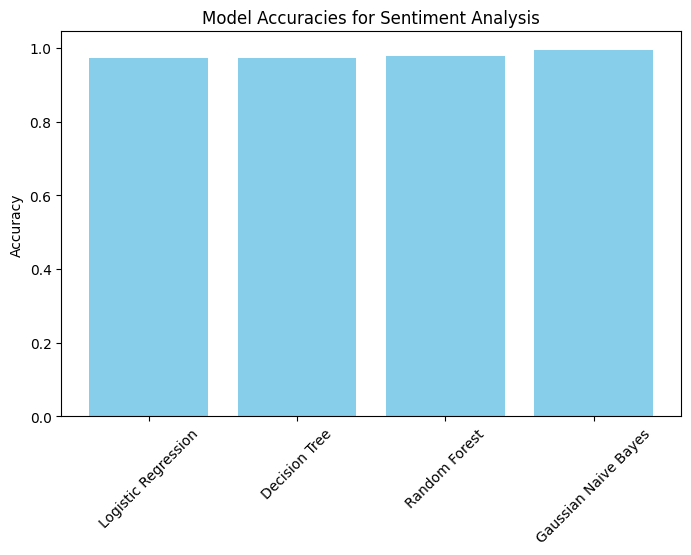

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.title('Model Accuracies for Sentiment Analysis')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()



In [ ]:
def predictnewreview():
    newreview = input("Type the review: ")
    if not newreview.strip():
        print("Invalid Review")
        return
    newreview = textcleaning(newreview)
    newreview = cv.transform([newreview]).toarray()
    prediction = models['Logistic Regression'].predict(newreview)
    print(f"The sentiment for the given review is: {prediction[0]}")


predictnewreview()



Type the review: This car has been a joy to drive! The ride quality is excellent, and I feel secure on the road, thanks to its advanced safety features. It’s easy to park and maneuver, and the fuel economy is impressive for a vehicle of this size. Very happy with my purchase!
The sentiment for the given review is: Positive


In [ ]:
def predictnewreview():
    newreview = input("Type the review: ")
    if not newreview.strip():
        print("Invalid Review")
        return
    newreview = textcleaning(newreview)
    newreview = cv.transform([newreview]).toarray()
    prediction = models['Logistic Regression'].predict(newreview)
    print(f"The sentiment for the given review is: {prediction[0]}")


predictnewreview()



Type the review: I regret buying this car. The engine has poor acceleration, and it feels sluggish when trying to merge onto highways. The air conditioning system doesn’t cool the cabin fast enough. Additionally, the sound system is disappointing for a car in this price range.
The sentiment for the given review is: Negative
